In [1]:
import csv
import math
import string
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from scipy.stats import linregress
from pandas_datareader import data as web
from qpsolvers import solve_qp
from qpsolvers import solve_ls
from cvxopt import matrix
from cvxopt import solvers


In [2]:
#Carregando a base de dados
#CCRO3.SA
#BBDC4.SA
#USIM5.SA
#ECOR3.SA
#df = web.DataReader('^BVSP', data_source='yahoo', start=f'02-20-2020', end='02-20-2021')
df = pd.read_csv('IBOV.csv')
df["Date"] = pd.to_datetime(df["Date"], format='%Y%m%d') 

In [3]:
def retorno(data, col):
    retorno = pd.DataFrame()
    for i in col:
        retorno[i] = data[i].pct_change().dropna().values
    return retorno

In [4]:
def variancia_global(retorno, a_inf, a_sup):
    
    col = retorno.columns.values
    sigmat = retorno.cov().to_numpy()
    r, c = np.shape(sigmat)
    wvec = np.arange(a_inf, a_sup, (a_sup - a_inf)/len(col))
    muvec   = retorno.mean().to_numpy()
    sigvec  = retorno.std().to_numpy()
    
    Amat = np.zeros([r+1, c+1])

    Amat[0:r, 0:c] = 2*sigmat
    Amat[0:r, -1] = 1
    Amat[-1, 0:c] = 1
    
    bavec = np.zeros([1, c+1])
    bavec[0, -1] = 1

    zmat = np.dot(np.linalg.inv(Amat),bavec.T)
    
    wvec2 = zmat[0:-1,0]
    
    mugmim = np.dot(wvec2, muvec)
    sig2gmim = np.dot(np.dot(wvec2.T,sigmat),wvec2)
    siggmim = np.sqrt(sig2gmim)
    
    print('Variância: ' + str(sig2gmim))
    print('Valor Esperado: ' + str(mugmim))
    print('Desvio ' + str(siggmim))
    

    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.bar(col, (wvec2*100))
    plt.xlabel('Ativos') 
    plt.ylabel('Pesos') 
  
    # displaying the title
    plt.title("Markowitz, portfolio de variância mínima global")
  
    plt.xticks(rotation=90)
    plt.show()
    
    return (wvec2, col)

In [5]:
#data_inicial = "01/01/2020"
#data_final = "01/01/2021"

#empresas_df = pd.read_excel("Empresas.xlsx")
#display(empresas_df)

#for empresa in empresas_df['Empresas']: 
#    print(f"{empresa}:")
#    df = web.DataReader(f'{empresa}.SA', data_source='yahoo', start=data_inicial, end=data_final)
#    display(df)
#    df["Adj Close"].plot(figsize=(15, 10))
#    plt.show()

In [6]:
def variancia_global2(retorno, a_inf, a_sup, u):
    
    #portifolio = '
    col = retorno.columns.values
    #port = np.where(col == portifolio)
    muvec   = retorno.mean().to_numpy()
    wvec = np.arange(a_inf, a_sup, (a_sup - a_inf)/len(col))

    sigmat = retorno.cov().to_numpy()
    r, c = np.shape(sigmat)
    Amat = np.zeros([r+2, c+2])

    Amat[0:r, 0:c] = 2*sigmat
    Amat[0:r, -1] = 1
    Amat[-1, 0:c] = 1
    Amat[0:r, -2] = muvec
    Amat[-2, 0:c] = muvec
    
    #u = muvec[port]
    
    bavec = np.zeros([1, c+2])
    bavec[0, -1] = 1
    bavec[0, -2] = u
    
    zmat = np.dot(np.linalg.inv(Amat),bavec.T)

    wavec = zmat[0:r,0]

    mupa = np.dot(zmat[0:r,0], wavec)

    sig2pa = np.dot(np.dot(wavec.T,sigmat), wavec)

    sigpa = np.sqrt(sig2pa)
    
    
    print('Variância: ' + str(sig2pa))
    print('Valor Esperado: ' + str(mupa))
    print('Desvio ' + str(sigpa))
    
 

    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.bar(col, (wvec*100))
    plt.xlabel('Ativos') 
    plt.ylabel('Pesos') 
  
    # displaying the title
    plt.title("Markowitz, portfolio de variância mínima global")
  
    plt.xticks(rotation=90)
    plt.show()
    
    return (wvec, col)

In [7]:
def variancia_global3(retorno, u):
    
    col = retorno.columns.values
    sigma = retorno.cov().to_numpy()
    mu   = retorno.mean().to_numpy()
    r, c = np.shape(sigma)
    
    #wt u >= 0
    #wt 1 >= 0 
    #wt 1 = 1
    P = sigma
    
    G = np.zeros([r+1, c])
    G[0,:] = mu
    for i in range(0,c):
        G[1+i, 0+i] =  1
    
    h = np.zeros([1,c+1])
    
    h[0,0] = u
    
    A = np.ones([1,c])
    
    b = np.array([1])
    
    q = np.zeros([1, c])
    
    wavec = solve_qp(P, q.reshape((c,)), -1*G, -1*h.reshape((c+1,)),  A.reshape((c,)), b)
    
    mupa = np.dot(wavec, mu)
    sig2pa = np.dot(np.dot(wavec.T,sigma), wavec)

    sigpa = np.sqrt(sig2pa)
    
    print('Variância: ' + str(sig2pa))
    print('Valor Esperado: ' + str(mupa))
    print('Desvio ' + str(sigpa))
    
    
    #wvec3 = wavec[wavec > 0]
    #col2 = col[np.where(wavec > 0)]
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.bar(col, (wavec*100))
    plt.xlabel('Ativos') 
    plt.ylabel('Pesos') 
  
    # displaying the title
    plt.title("Markowitz, portfolio de variância mínima global")
  
    plt.xticks(rotation=90)
    plt.show()
    
    return (wavec, col)
    
    #P = matrix(P, tc='d')
    #G = matrix(G, tc='d')
    #h = matrix(h.T, tc='d')
    #q = matrix(q.T, tc='d')
    #b = matrix(b, tc='d')
    #A = matrix(A, tc='d')
    
    #sol = solvers.qp(P, q, G, h,  A, b)
    
    #print(sol['x'])
    

in_sample
Variância: 3.67331732243898e-05
Valor Esperado: 0.001125800769183724
Desvio 0.006060789818529413


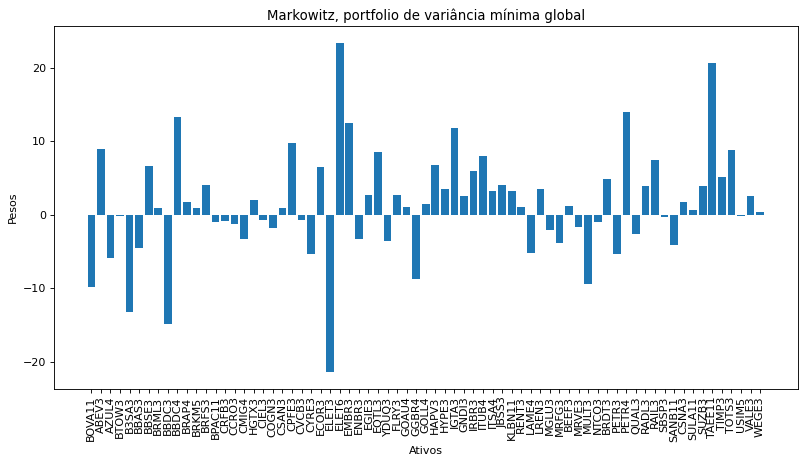

In [8]:

print('in_sample')
data_in_sample = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2020-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample1, coluna1 = variancia_global(retorno_in_sample, -0.0001, 0.0001)



in_sample
Variância: 5.824159705822777e-05
Valor Esperado: 0.0015542274116143516
Desvio 0.007631618246363465


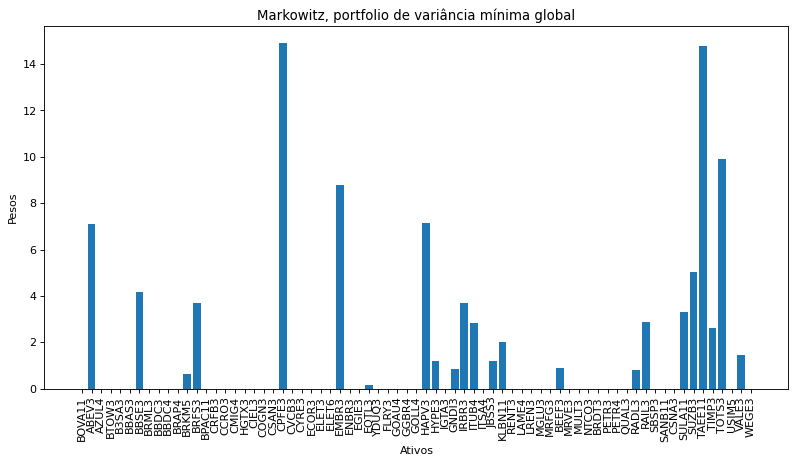

In [9]:


print('in_sample')
data_in_sample = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2020-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample2, coluna2 = variancia_global3(retorno_in_sample, 0)



in_sample
Variância: 8.01216671948542e-05
Valor Esperado: 0.003
Desvio 0.008951070728960541


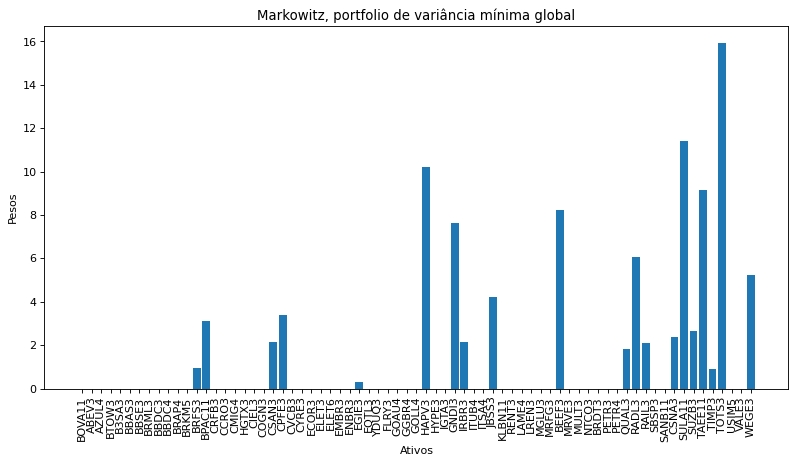

In [10]:


print('in_sample')
data_in_sample = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2020-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample3, coluna3 = variancia_global3(retorno_in_sample,0.3/100)



In [35]:
def norm(data):
    data = (data - data.min())/(data.max() - data.min())
    return data

data_in_sample = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-01-01')]
data = data_in_sample.copy()
data = norm(data['IBOV'])

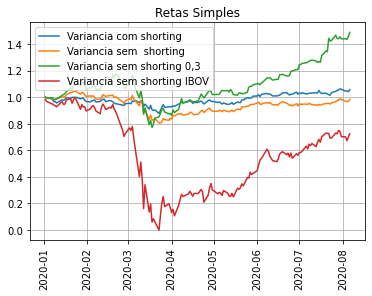

In [36]:
data_out_of_sample = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-01-01')]

col = data_out_of_sample.columns.values
d = data_out_of_sample[col[0]]
#xmim = data_out_of_sample[col[2:len(col)]].min()
#xmax = data_out_of_sample[col[2:len(col)]].max()
#data_out_of_sample = data_out_of_sample[col[2:len(col)]]
#retonro__out_of_sample = retorno(data_out_of_sample, col[2:len(col)])
#data_out_of_sample = (x - xmim)/(xmax - xmim)
c = 1


wi = [w_in_sample1, w_in_sample2, w_in_sample3]
coluna = [coluna1, coluna2, coluna3]

Vt = []
for j in range(0,len(wi)):
    Pit = data_out_of_sample[coluna[j]].values
    xi =  c*wi[j]/Pit[0]
    Vt.append(np.sum(xi*Pit, axis = 1))

plt.figure(figsize=(6, 4))
plt.plot(d, Vt[0], label='Variancia com shorting') # green
plt.plot(d, Vt[1], label='Variancia sem  shorting')
plt.plot(d, Vt[2], label='Variancia sem shorting 0,3') # yellow
plt.plot(d, data, label='Variancia sem shorting IBOV') # yellow

plt.grid(True)
plt.title('Retas Simples')
plt.legend()
plt.xticks(rotation=90)
plt.show()
#plt.savefig('reta-titulo-legendas.png')
#plt.close()

out_of_sample
Variância: 0.0007334369263679643
Valor Esperado: 0.002999999999999994
Desvio 0.027082040661072133


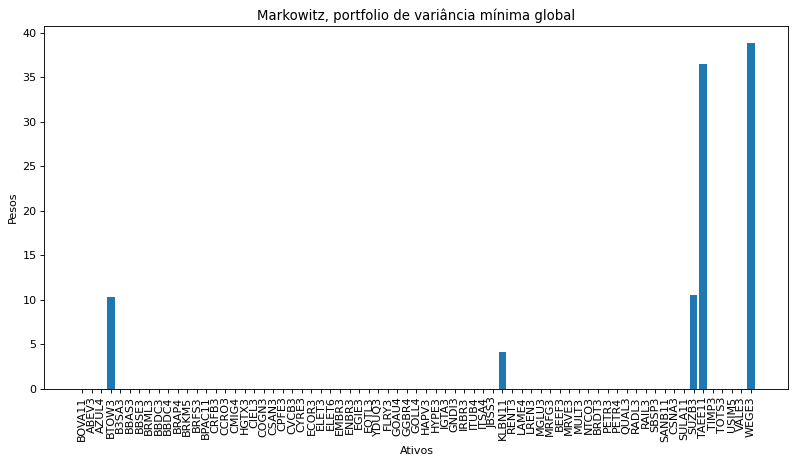

In [20]:
print('out_of_sample')
data_in_sample = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample3, coluna3 = variancia_global3(retorno_in_sample,0.3/100)


out_of_sample
Variância: 0.0002975911725706195
Valor Esperado: 0.00013209868826844536
Desvio 0.01725083106898388


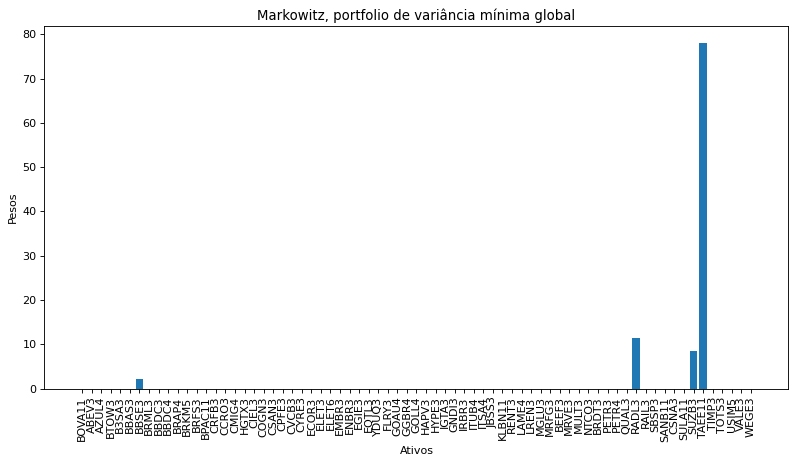

In [21]:
print('out_of_sample')

data_in_sample = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample2, coluna2 = variancia_global3(retorno_in_sample, 0)


out_of_sample
Variância: 8.81734294931677e-05
Valor Esperado: -9.113071898587673e-05
Desvio 0.009390070792766565


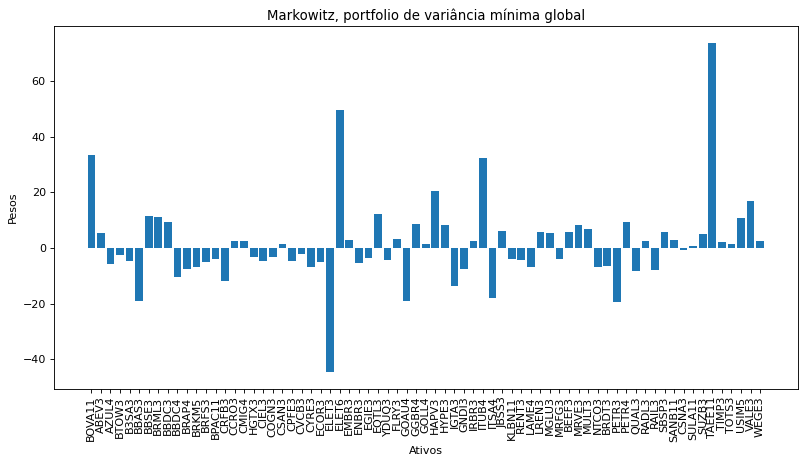

In [22]:
print('out_of_sample')
data_in_sample = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-01-01')]
col = data_in_sample.columns.values
col = col[2:len(col)]
retorno_in_sample = retorno(data_in_sample, col)
w_in_sample1, coluna1 = variancia_global(retorno_in_sample, -0.0001, 0.0001)
